# Taylor Window

https://www.recordingblogs.com/wiki/dolph-chebychev-window

https://ccrma.stanford.edu/~jos/sasp/Dolph_Chebyshev_Window.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.taylor.html?highlight=window

```
def taylor(M, nbar=4, sll=30, norm=True, sym=True):
    """
    Return a Taylor window.
    The Taylor window taper function approximates the Dolph-Chebyshev window's
    constant sidelobe level for a parameterized number of near-in sidelobes,
    but then allows a taper beyond [2]_.
    The SAR (synthetic aperature radar) community commonly uses Taylor
    weighting for image formation processing because it provides strong,
    selectable sidelobe suppression with minimum broadening of the
    mainlobe [1]_.
    Parameters
    ----------
    M : int
        Number of points in the output window. If zero or less, an
        empty array is returned.
    nbar : int, optional
        Number of nearly constant level sidelobes adjacent to the mainlobe.
    sll : float, optional
        Desired suppression of sidelobe level in decibels (dB) relative to the
        DC gain of the mainlobe. This should be a positive number.
    norm : bool, optional
        When True (default), divides the window by the largest (middle) value
        for odd-length windows or the value that would occur between the two
        repeated middle values for even-length windows such that all values
        are less than or equal to 1. When False the DC gain will remain at 1
        (0 dB) and the sidelobes will be `sll` dB down.
    sym : bool, optional
        When True (default), generates a symmetric window, for use in filter
        design.
        When False, generates a periodic window, for use in spectral analysis.
    Returns
    -------
    out : array
        The window. When `norm` is True (default), the maximum value is
        normalized to 1 (though the value 1 does not appear if `M` is
        even and `sym` is True).
    See Also
    --------
    chebwin, kaiser, bartlett, blackman, hamming, hann
    References
    ----------
    .. [1] W. Carrara, R. Goodman, and R. Majewski, "Spotlight Synthetic
           Aperture Radar: Signal Processing Algorithms" Pages 512-513,
           July 1995.
    .. [2] Armin Doerry, "Catalog of Window Taper Functions for
           Sidelobe Control", 2017.
           https://www.researchgate.net/profile/Armin_Doerry/publication/316281181_Catalog_of_Window_Taper_Functions_for_Sidelobe_Control/links/58f92cb2a6fdccb121c9d54d/Catalog-of-Window-Taper-Functions-for-Sidelobe-Control.pdf
    Examples
    --------
    Plot the window and its frequency response:
    >>> from scipy import signal
    >>> from scipy.fft import fft, fftshift
    >>> import matplotlib.pyplot as plt
    >>> window = signal.windows.taylor(51, nbar=20, sll=100, norm=False)
    >>> plt.plot(window)
    >>> plt.title("Taylor window (100 dB)")
    >>> plt.ylabel("Amplitude")
    >>> plt.xlabel("Sample")
    >>> plt.figure()
    >>> A = fft(window, 2048) / (len(window)/2.0)
    >>> freq = np.linspace(-0.5, 0.5, len(A))
    >>> response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    >>> plt.plot(freq, response)
    >>> plt.axis([-0.5, 0.5, -120, 0])
    >>> plt.title("Frequency response of the Taylor window (100 dB)")
    >>> plt.ylabel("Normalized magnitude [dB]")
    >>> plt.xlabel("Normalized frequency [cycles per sample]")
    """  # noqa: E501
    if _len_guards(M):
        return np.ones(M)
    M, needs_trunc = _extend(M, sym)

    # Original text uses a negative sidelobe level parameter and then negates
    # it in the calculation of B. To keep consistent with other methods we
    # assume the sidelobe level parameter to be positive.
    B = 10**(sll / 20)
    A = np.arccosh(B) / np.pi
    s2 = nbar**2 / (A**2 + (nbar - 0.5)**2)
    ma = np.arange(1, nbar)

    Fm = np.empty(nbar-1)
    signs = np.empty_like(ma)
    signs[::2] = 1
    signs[1::2] = -1
    m2 = ma*ma
    for mi, m in enumerate(ma):
        numer = signs[mi] * np.prod(1 - m2[mi]/s2/(A**2 + (ma - 0.5)**2))
        denom = 2 * np.prod(1 - m2[mi]/m2[:mi]) * np.prod(1 - m2[mi]/m2[mi+1:])
        Fm[mi] = numer / denom

    def W(n):
        return 1 + 2*np.dot(Fm, np.cos(
            2*np.pi*ma[:, np.newaxis]*(n-M/2.+0.5)/M))

    w = W(np.arange(M))

    # normalize (Note that this is not described in the original text [1])
    if norm:
        scale = 1.0 / W((M - 1) / 2)
        w *= scale

    return _truncate(w, needs_trunc)
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as dsp
import scipy.fftpack as fft
import IPython.display as display
from zplot import zplot
from compare import compare

$$
T_{2M} = \begin{cases}
\cos(2M\mathrm{acos}(x))   & |x| \le 1 \\
\cosh(2M\mathrm{acosh}(x)) & |x|  >  1
\end{cases}
$$

In [2]:
def T(x: np.ndarray, M: float, inplace=False):
    if not inplace:
        x = x.copy()
    mask = abs(x) <= 1
    x[ mask] = np.cos( 2 * M * np.arccos( x[ mask]))
    x[~mask] = np.cosh(2 * M * np.arccosh(x[~mask]))
    return x

$$
w[n] = 
$$

In [3]:
def taylor(N, sym=False, w0=0.1, norm=True):
    """
    Return a Taylor window.

    Args:
        N: Number of points in the output window. 
        If zero or less, an empty array is returned.
        sym: When True (default), generates a symmetric window, 
        for use in filter design. When False, generates a 
        periodic window, for use in spectral analysis.

    Returns:
        the Taylor window of length N with given symmetry

    Details:
        The Taylor window is an approximation of the Dolph-Chebychev window.

    """
    n = np.arange(N)
    N = N - 1 if sym else N
    M = N / 2
    wm = np.pi * np.arange(M) / N
    rational = T(np.cos(wm / 2) / np.cos(w0 / 2), M) / T(np.array(1 / np.cos(w0 / 2)), M)

    n = np.repeat(n[:, None], len(rational), 1) - M
    wm = np.repeat(wm[None, :], len(n), 0)
    window = (np.repeat(rational[None, :], len(n), 0) * np.cos(wm * n)).sum(-1)# / N
    if norm:
        window /= window[int(M)]
    return window

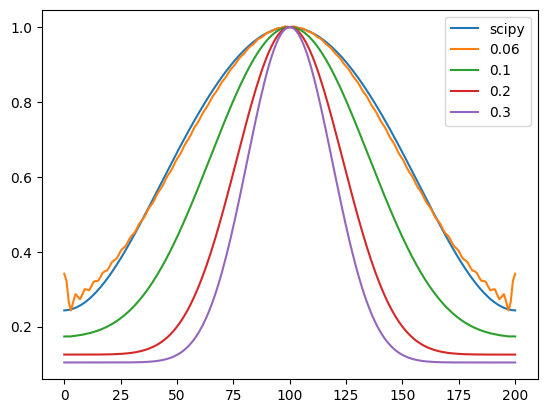

In [4]:
plt.plot(dsp.windows.taylor(201, sym=True), label='scipy')
plt.plot(taylor(201, w0=0.06, sym=True), label='0.06')
plt.plot(taylor(201, w0=0.1, sym=True), label='0.1')
plt.plot(taylor(201, w0=0.2, sym=True), label='0.2')
plt.plot(taylor(201, w0=0.3, sym=True), label='0.3')
plt.legend()

## Asymmetric

### Odd

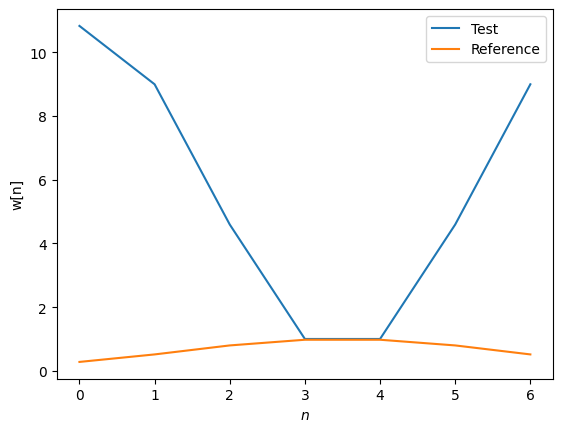

In [5]:
test, reference = compare(7, taylor, dsp.windows.taylor, False)

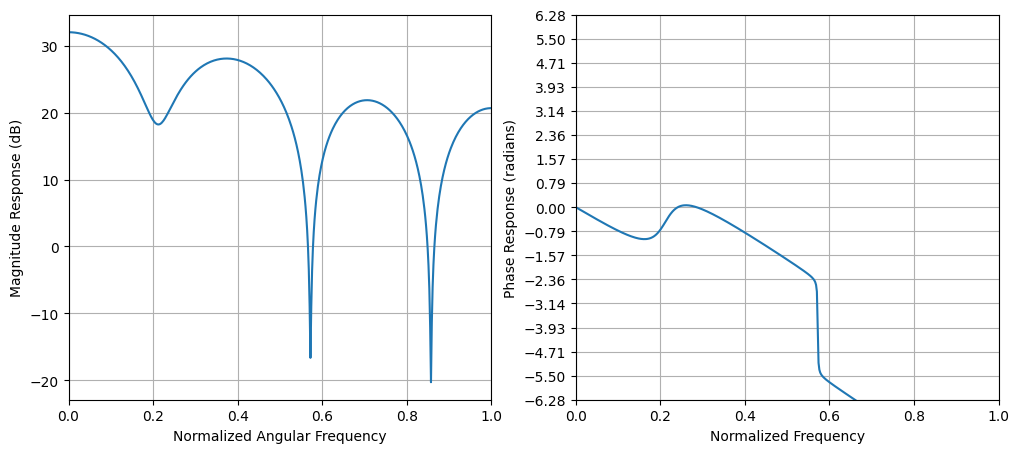

In [6]:
_ = dsp.freqz(test, plot=zplot)

In [7]:
list(test)

[10.829699781044125,
 8.99717264547241,
 4.593862098904512,
 1.0,
 1.0,
 4.593862098904512,
 8.99717264547241]

In [8]:
list(reference)

[0.2793462998238399,
 0.5149598981910933,
 0.7973015281194145,
 0.9756107180961113,
 0.9756107180961113,
 0.7973015281194145,
 0.5149598981910933]

### Even

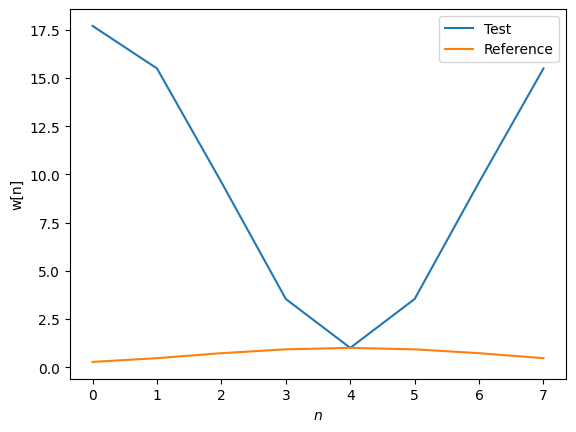

In [9]:
test, reference = compare(8, taylor, dsp.windows.taylor, False)

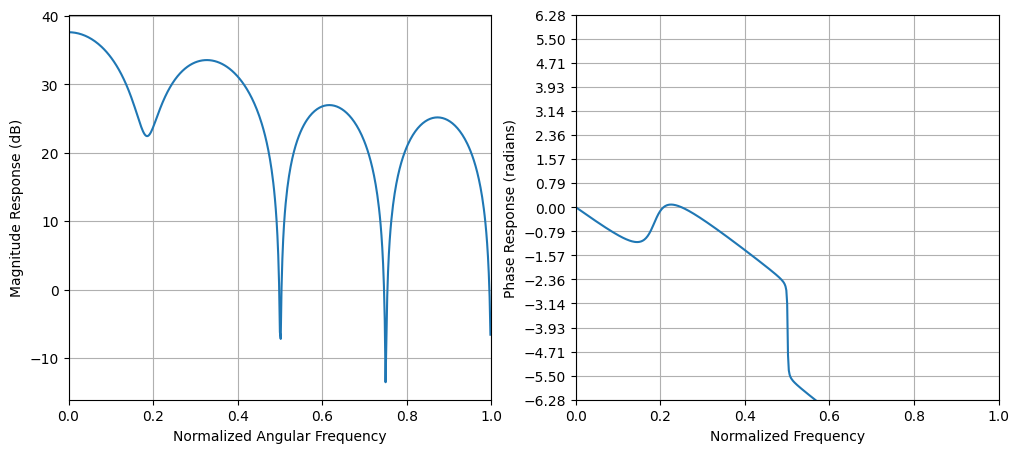

In [10]:
_ = dsp.freqz(test, plot=zplot)

In [11]:
list(test)

[17.700481046498208,
 15.494079515420825,
 9.59435441455783,
 3.536403077761312,
 1.0,
 3.536403077761312,
 9.59435441455783,
 15.494079515420825]

In [12]:
list(reference)

[0.2718834924087382,
 0.46690631985001974,
 0.7246751121792886,
 0.92465582532122,
 1.0,
 0.92465582532122,
 0.7246751121792886,
 0.46690631985001974]

## Symmetric

### Odd

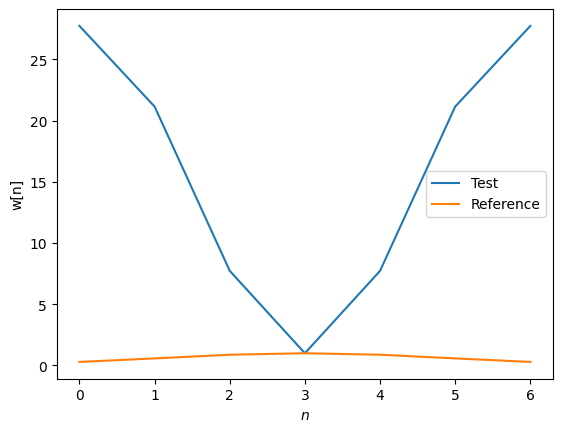

In [13]:
test, reference = compare(7, taylor, dsp.windows.taylor, True)

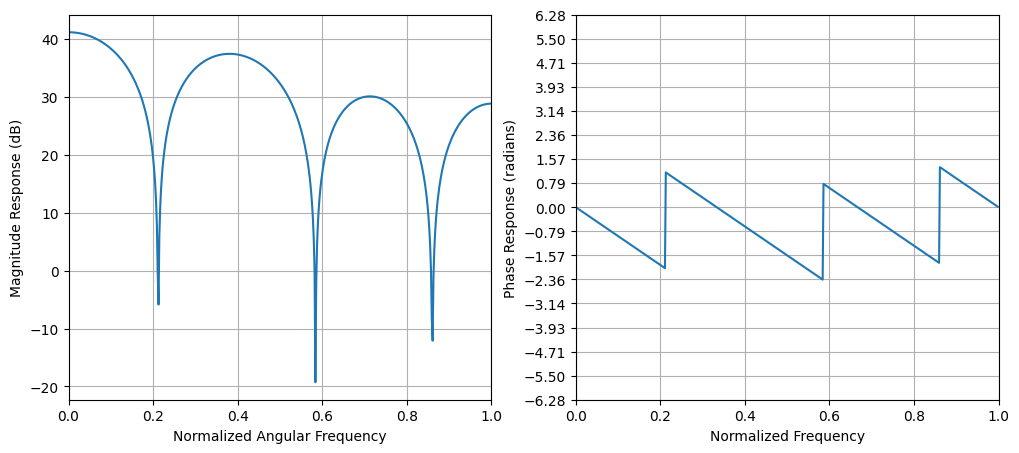

In [14]:
_ = dsp.freqz(test, plot=zplot)

In [15]:
list(test)

[27.741832049805794,
 21.152216965570787,
 7.72993887023623,
 1.0,
 7.72993887023623,
 21.152216965570787,
 27.741832049805794]

In [16]:
list(reference)

[0.2900953127271472,
 0.5782126011092212,
 0.8780082248652833,
 1.0,
 0.8780082248652833,
 0.5782126011092212,
 0.2900953127271472]

### Even

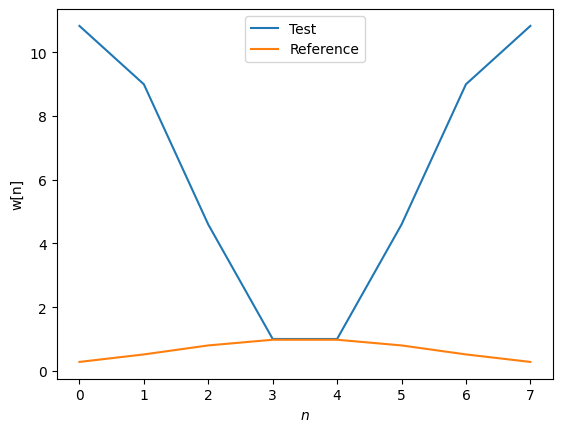

In [17]:
test, reference = compare(8, taylor, dsp.windows.taylor, True)

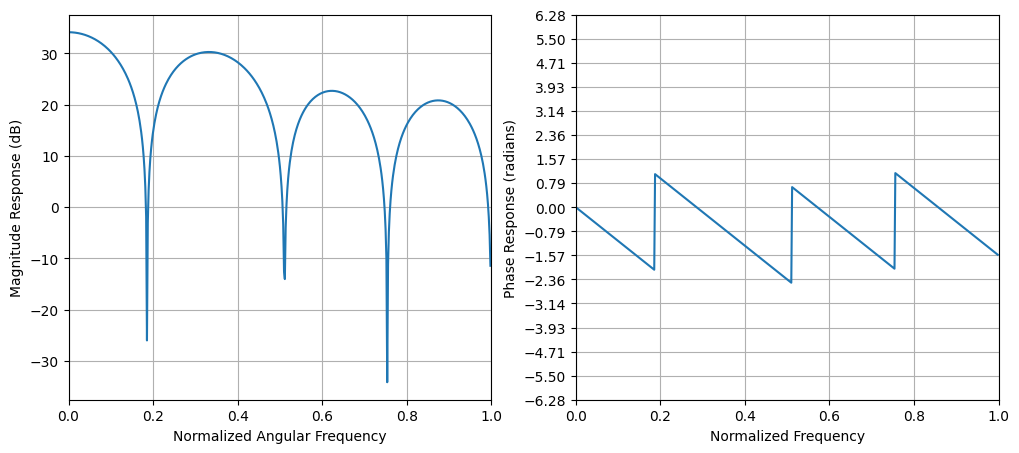

In [18]:
_ = dsp.freqz(test, plot=zplot)

In [19]:
list(test)

[10.829699781044125,
 8.99717264547241,
 4.593862098904512,
 1.0,
 1.0,
 4.593862098904512,
 8.99717264547241,
 10.829699781044125]

In [20]:
list(reference)

[0.2793462998238399,
 0.5149598981910933,
 0.7973015281194145,
 0.9756107180961113,
 0.9756107180961113,
 0.7973015281194145,
 0.5149598981910933,
 0.2793462998238399]

## Coherent gain

In [21]:
taylor(1024, False).mean()

0.24327115833234728

## Side-lobe amplitude

-11.3906741649031

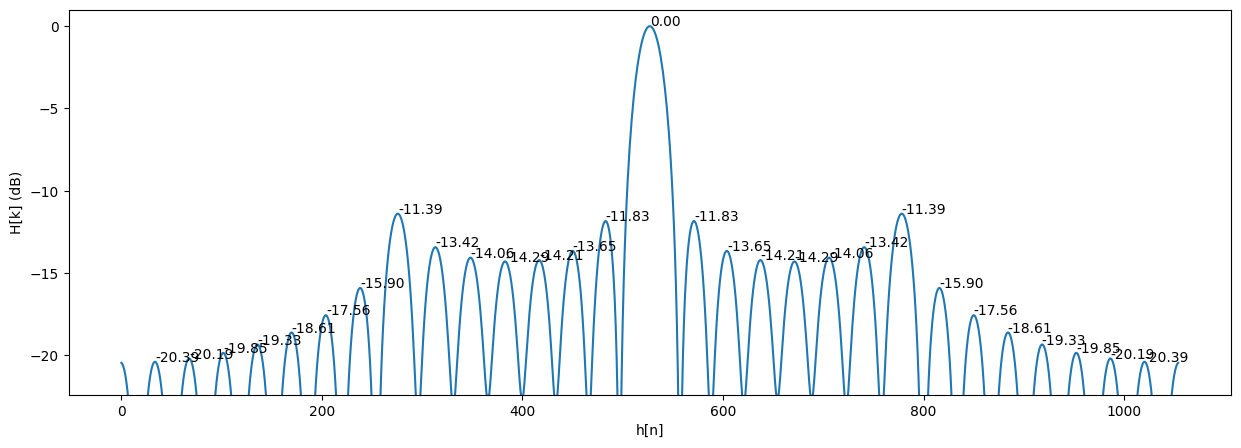

In [22]:
w = taylor(31, False)
w = np.pad(w, (512, 512))
H = fft.fft(w)
H = fft.fftshift(H)
H = 20 * np.log10(np.abs(H) + 1e-12)
H = H - H.max()
peaks, _ = dsp.find_peaks(H)
ymin = H[peaks[len(peaks)//2:]][-1] - 1
plt.figure(figsize=(15, 5))
plt.plot(H)
for x, y in zip(peaks, H[peaks]):
    if y > ymin:
        plt.text(x, y, f'{y:.2f}')
plt.ylabel('H[k] (dB)')
plt.xlabel('h[n]')
plt.ylim(ymin - 1, 1)
sorted(H[peaks], reverse=True)[1]